# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [50]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


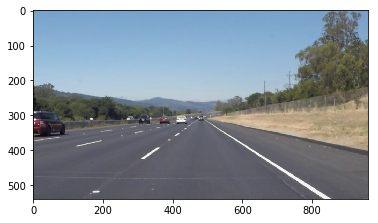

In [51]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [85]:
import math
from pylab import *
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from sklearn import linear_model as lm

# initialize counter
count = 0
#global count
prevlreg = 0
#global prevlreg
prevrreg = 0
#global prevrreg
left_weight = 10
#global left_weight
prev_left_wt = 10
#global prev_left_wt
right_weight = 10
#global right_weight
prev_right_wt = 10
#global prev_right_wt
challenge_output = ''
#global challenge_output

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    

def draw_lines(img, lines, vertices, left_regr, right_regr, color=[255, 0, 0], thickness=10):
    
    
    global prev_left_wt, prev_right_wt
    
    # The coefficients for left line
    left_slope = ((left_regr.coef_ * left_weight**5) + (prevlreg.coef_ * prev_left_wt**5))/(left_weight**5 + prev_left_wt**5)
    left_int = ((left_regr.intercept_ * left_weight**5) + (prevlreg.intercept_ * prev_left_wt**5))/(left_weight**5 + prev_left_wt**5)
    
    # Check for left slope out of range or absent lane line, set default values if out of range
    if left_slope > -.5:
        left_slope = -.65
        left_int = 0.65*img.shape[1]

    # The coefficients for right line
    right_slope = (((right_regr.coef_ * right_weight**5) + (prevrreg.coef_ * prev_right_wt**5))/(right_weight**5 + prev_right_wt**5))
    right_int = ((right_regr.intercept_ * right_weight**5) + (prevrreg.intercept_ * prev_right_wt**5))/(right_weight**5 + prev_right_wt**5)
    
    # Check for right slope out of range or absent lane line, set default values if out of range
    if right_slope < .5:
        right_slope = .63
        right_int = 0.001*img.shape[0]

    # Define the points to draw the solid regression lines
    left_bottom_x = 0
    left_bottom_y = int(left_int)
        
    left_top_x = int((vertices[0][1][1]-left_int)/(left_slope + .0001))
    left_top_y = vertices[0][1][1]             
               
    left_pair1 = (left_bottom_x, left_bottom_y)
    left_pair2 = (left_top_x, left_top_y)
    
    right_bottom_x = int((img.shape[0]-right_int)/(right_slope + .0001))
    right_bottom_y = img.shape[0]
        
    right_top_x = int((vertices[0][1][1]-right_int)/(right_slope + .0001))
    right_top_y = vertices[0][1][1]             
               
    right_pair1 = (right_bottom_x, right_bottom_y)
    right_pair2 = (right_top_x, right_top_y)
    
    # Draw the regression lines set regression = 1 for regression line overlay
    regression = 1
    if regression == 1:
        cv2.line(img, left_pair1, left_pair2, color, thickness)
        cv2.line(img, right_pair1, right_pair2, color, thickness)
    
    # Assign the current weighting to the previous holders for next iteration
    prev_left_wt = left_weight
    prev_right_wt = right_weight
    
    # Draw the Hough lines that regression was based on. set hough = 1 for Hough line overlay
    hough = 1
    if hough == 1:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], 2)
            
    return left_regr, right_regr


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    # Write access for counter variable
    global count
    # Create Hough lines and blank image to draw them on
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    left_regr, right_regr = linregr(lines, img)
            
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines, vertices, left_regr, right_regr)
    
    count += 1
    
    return line_img

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def color_mask(img,  vertices):
        
    # Grab the x and y sizes and make two copies of the image
    # With one copy we'll extract only the pixels that meet our selection,
    # then we'll paint those pixels red in the original image to see our selection 
    # overlaid on the original.
    ysize = img.shape[0]
    xsize = img.shape[1]
    color_filtered= np.copy(img)
    line_image = np.copy(img)
    
    # Define our color criteria tuned for yellows and whites
    red_threshold = 200
    green_threshold = 189
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    
    # Define polygon vertices for masking
    left_bottom = vertices[0][0]
    right_bottom = vertices[0][3]
    left_top = vertices[0][1]
    right_top = vertices[0][2]
    
    fit_left = np.polyfit((left_bottom[0], left_top[0]), (left_bottom[1], left_top[1]), 1)
    fit_right = np.polyfit((right_bottom[0], right_top[0]), (right_bottom[1], right_top[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)
    fit_top = np.polyfit((left_top[0], right_top[0]), (left_top[1], right_top[1]), 1)
    
    # Mask pixels below the threshold
    color_thresholds = (img[:,:,0] < rgb_threshold[0]) | \
                        (img[:,:,1] < rgb_threshold[1]) | \
                        (img[:,:,2] < rgb_threshold[2])
    
    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1])) & \
                        (YY > (XX*fit_top[0] + fit_top[1]))
                        
    # Mask color selection
    color_filtered[color_thresholds] = [0,0,0]
    
    # Find where image is both colored right and in the region
    line_image[~color_thresholds & region_thresholds] = [255,0,0]
    color_filtered[~color_thresholds & region_thresholds] = [255,0,0]
    
    return line_image, color_filtered


def linregr(lines, img):
    
    """
    Does a linear regression on the Hough lines. It first segregates
    the data into left line and right line by splitting the screen at a 
    tuneable location. Regression is sourced from scikit-learn.com. 
    """
    # Give write access to globals
    global prevlreg, prevrreg, left_weight
    
    # Initialize lists and arrays, assign screen splitting percentage
    left_lines = []
    right_lines = []
    left_xs = np.array([[]])
    right_xs = np.array([[]])
    left_ys = np.array([[]])
    right_ys = np.array([[]])
    screen_split = 0.52
    
    # Iterate through Hough lines to segregate left and right            
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 < img.shape[1]*screen_split:
                left_xs = np.append(left_xs, x2)
                left_ys = np.append(left_ys, y2)
                left_lines.append((x2,y2))
                left_weight = len(lines)
            else:
                right_xs = np.append(right_xs, x1)
                right_ys = np.append(right_ys, y1)
                right_lines.append((x1,y1))
                right_weight = len(lines)
    
    # populate array if empty to prevent Traceback error on empty array
    if not left_xs.size:
        left_xs = np.append(left_xs, x1)
    if not left_ys.size:
        left_ys = np.append(left_ys, y1)
    
    # Create linear regression object left line  
    left_xs = np.reshape(left_xs,(size(left_xs),1))    
    left_regr = lm.LinearRegression().fit(left_xs, left_ys)
    prevlreg = left_regr # store current regression as previous for next iteration
    
    # populate array if empty to prevent Traceback error on empty array
    if not right_xs.size:
        right_xs = np.append(right_xs, x1)
    if not right_ys.size:
        right_ys = np.append(right_ys, y1)
    
    # Create linear regression object right line   
    right_xs = np.reshape(right_xs,(size(right_xs),1))    
    right_regr = lm.LinearRegression().fit(right_xs, right_ys)
    prevrreg = right_regr # store current regression as previous for next iteration
    
    return left_regr, right_regr

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [86]:
# import os commands and display current directory
import os
os.getcwd()

'/Users/KrazyK/Documents/Udacity/CarND-LaneLines-P1'

In [87]:
test_images = os.listdir("test_images/") # store test images into variable for later
print(test_images)
image = mpimg.imread(os.getcwd()+'/test_images/'+test_images[2]) # cycle through test images by changing test_images index

['.DS_Store', 'challenge.jpeg', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [88]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def pipeline(image):    
    
    # Define polygon vertices
    imshape = image.shape
    
    if challenge_output == 'extra.mp4':
        # Challenge Values
        lbxper = .15 # left bottom x vertice percentage
        rbxper = .88 # right bottom x vertice percentage 
        byper = .92 # bottom y vertices percentage 
        typer = .61 # top y vertices percentage
        lm = -0.39 # left slope 
        rm = 0.55 # righty slope 
    else:
        # White and yellow video Values
        lbxper = .15 # left bottom x vertice percentage
        rbxper = .95 # right bottom x vertice percentage
        byper = 1 # bottom y vertices percentage
        typer = .61 # top y vertices percentage
        lm = -0.51 # left slope 
        rm = 0.6 # right slope
        
    # Vertices calculations
    xlb = imshape[1]*lbxper
    ylb = imshape[0]*byper
    xlt = (imshape[0]*typer - ylb)/lm
    ylt = imshape[0]*typer
    xrb = imshape[1]*rbxper
    yrb = ylb
    xrt = (ylt - ylb)/rm + xrb
    yrt = ylt
     
    vertices = np.array([[(xlb,ylb),(xlt, ylt), (xrt, yrt), (xrb,yrb)]], dtype=np.int32)
    
    # Color filter the image and highlight points after mask
    color_region, color_filt_mask = color_mask(image,  vertices)
#    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
#    blur_gray = gaussian_blur(gray, kernel_size)
    blur_color = gaussian_blur(color_filt_mask, kernel_size)
    
    # Define parameters and apply Canny edge detection
    low_threshold = 20
    high_threshold = 150
#    edges = canny(blur_gray, low_threshold, high_threshold)
    edges = canny(blur_color, low_threshold, high_threshold)

    # Mask out everything except the region of interest
    masked_edges = region_of_interest(edges, vertices)

    # Define parameters and create Hough lines to draw later
    rho =1 # distance resolution in pixels of the Hough grid
    theta = np.pi*1/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, vertices)

    
    # Overlay Hough lines and original image with option for semi-transparency
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    return result, masked_edges, lines, image, color_region, color_filt_mask, blur_color, edges

result, masked_edges, lines, image, color_region, color_filt_mask, blur_color, edges = pipeline(image)



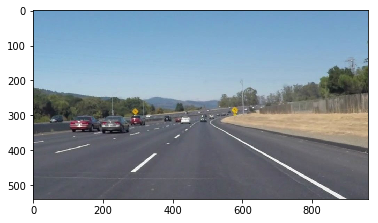

'Original -  .DS_Store '


In [89]:
plt.imshow(image) #show original only
plt.show()
print("'Original - ",test_images[0],"'")

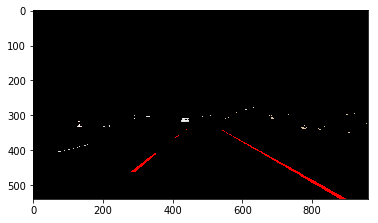

Color filtered and region masked


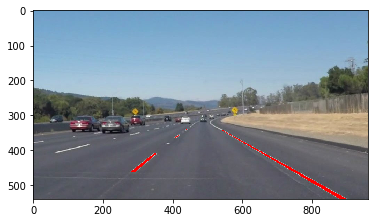

Color and region filtered overlayed on original


In [90]:
# Display our two output images from color masking
plt.imshow(color_filt_mask)
plt.show()
print('Color filtered and region masked')
plt.imshow(color_region)
plt.show()
print('Color and region filtered overlayed on original')
mpimg.imsave('output_images/ColorRegionImage.jpg', color_region) # Color filtered mask overlayed saved
mpimg.imsave('output_images/ColorRegionMask.jpg', color_filt_mask) #Color filtered and masked saved
mpimg.imsave('output_images/GaussianBlur.jpg', blur_color) # Gaussian color blur saved

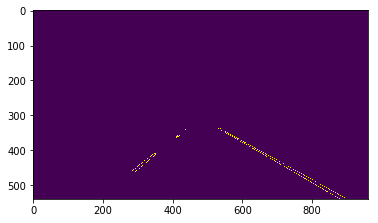

Masked edges only


In [91]:
plt.imshow(masked_edges) # show edges only
plt.show()
print('Masked edges only')
mpimg.imsave('output_images/MaskedEdges.jpg', masked_edges)
mpimg.imsave('output_images/CannyEdges.jpg', edges)

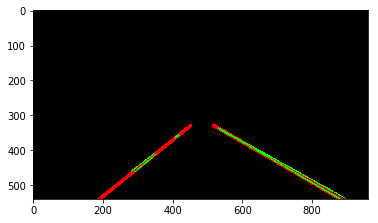

Hough lines in green with regression fit overlay in red


In [92]:
plt.imshow(lines) # show hough lines only
plt.show()
print('Hough lines in green with regression fit overlay in red')
mpimg.imsave('output_images/HoughLine.jpg', lines)

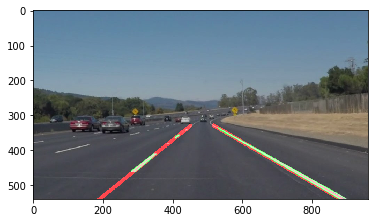

Final result overlayed on original image


In [93]:
# Plot the resulting image to verify output
plt.imshow(result)
plt.show()
print('Final result overlayed on original image')
mpimg.imsave('output_images/FinalResult.jpg', result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [71]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [72]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result, masked_edges, lines, image, color_region, color_filt_mask, blur_color, edges = pipeline(image)

    return result

Let's try the one with the solid white lane on the right first ...

In [73]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 9.88 s, sys: 2.63 s, total: 12.5 s
Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [75]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:32<00:00, 21.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 30.6 s, sys: 8.06 s, total: 38.6 s
Wall time: 32.6 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [42]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:22<00:00, 11.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 20.2 s, sys: 6.87 s, total: 27.1 s
Wall time: 23.2 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))